## Function 4
1. Load the provided initial data.
2. Visualize the current data to understand its structure.
3. Fit a Gaussian Process (GP) surrogate model.
4. Use Bayesian optimization to suggest the next best point(s).

The problem described for Function 4 ("Fast, but Inaccurate Modelling") closely aligns with the scenario presented by Bayesian Optimisation with Gaussian Processes, specifically using Gaussian Processes as a surrogate model. This method has been extensively covered in Module 12 of the course (Bayesian Optimisation).

Reasoning:
The scenario describes a situation with an expensive-to-evaluate function (accurate calculations that can only be done infrequently).
The business seeks a quicker approximation, exactly matching the concept of a surrogate model, which approximates the expensive original function at lower computational cost.
The description mentions "a lot of local optima," a situation where Gaussian Processes are particularly effective due to their built-in uncertainty quantification and their ability to balance exploration and exploitation.
Approach Recommended:
Gaussian Process Regression as a surrogate model.
An acquisition function suited for managing multiple local optima: typically, Expected Improvement (EI) or Upper Confidence Bound (UCB).
Likely hyperparameters optimized:
The problem specifically mentions 4 hyperparameters, typically associated with common ML surrogate models, such as:

Hyperparameters controlling model complexity (e.g., depth, complexity, regularization strength)
Parameters defining approximation precision (e.g., kernel parameters of Gaussian Process or model structure)
Proposed Action:
Incorporate explicitly Gaussian Processes as surrogate models and an appropriate acquisition function (EI or UCB) explicitly tailored to handle the described complexity of Function 4.

In [1]:
# update data weekly
import numpy as np
import os

# Function number (update this as needed)
function_id = 4  # change for f2, f3, etc.

# Load original data
inputs_path = f'function_{function_id}/initial_inputs.npy'
outputs_path = f'function_{function_id}/initial_outputs.npy'
inputs = np.load(inputs_path)
outputs = np.load(outputs_path)

# Load new data (replace this with your actual new submissions)
# Example: new 2D point with corresponding output
# week1: 0.542872	0.477129	0.465693	0.474096	and -4.344949998
# week2: 0.424225	0.418432	0.378556	0.391309	and 0.508302274
# week3_1t: 0.439165	0.675294	0.36297	0.671509 and -9.658848133752013
# week3_2f: 0.536134	0.481355	0.459940	0.477570	and -3.951088934
# w4-1t: 0.526134	0.381355	0.459940	0.377570	and -2.282544887
# w4-2f: 0.535849	0.478498	0.559940	0.474713	and -5.576070716
# w5-1t: 0.535849	0.478498	0.462717	0.474713	and -3.958120872
# W5-2F: 0.435849	0.478498	0.462717	0.374713	AND -1.58090957602171
# w6-1t: 0.533217	0.478498	0.462717	0.472081  and -3.80483222440159
# w6-2f: 0.425225	0.419432	0.368556	0.399309 and 0.617815926215989
# w7-1t: 0.424225	0.415432	0.376556	0.390309 and 0.510505242813903
# w7-2f: 0.434225	0.415432	0.376556	0.392309 and 0.384771612885402
# w8-1t: 0.434225	0.420432	0.366556	0.392309 and 0.510505242813903
# w8-2f: 0.434225	0.415432	0.376556	0.393309 and 0.388484516395685
# w9-1t: 0.435225	0.420032	0.366556	0.392009 and 0.462230048334682
# W9-2f: 0.420225	0.419422	0.368506	0.398309 and 0.635365229
# w10-1t: 0.420005	0.419022	0.369506	0.399309 and 0.634870988391263
# w10-2f: 0.386279	0.391579	0.331700	0.395632 and -0.306798027


new_inputs = np.array([[0.386279, 0.391579, 0.331700, 0.395632]])
new_outputs = np.array([-0.306798027])

# Concatenate new data to existing
updated_inputs = np.vstack([inputs, new_inputs])
updated_outputs = np.concatenate([outputs, new_outputs])
print("updated_inputs shape:", updated_inputs.shape)
print("updated_outputs shape:", updated_outputs.shape)
# Optionally: save backup copies before overwriting
np.save(f'function_{function_id}/backup_inputs.npy', inputs)
np.save(f'function_{function_id}/backup_outputs.npy', outputs)

# Save updated files
np.save(inputs_path, updated_inputs)
np.save(outputs_path, updated_outputs)

print("Updated data saved.")

updated_inputs shape: (48, 4)
updated_outputs shape: (48,)
Updated data saved.


Fitted kernel: 2.97**2 * Matern(length_scale=1.56, nu=2.5)
Suggested next best input (model hyperparameters): [0.51269429 0.46661729 0.44472971 0.45758265]
Suggested next best input (6 decimals): ['0.512694', '0.466617', '0.444730', '0.457583']
Predicted performance gap at suggested input: -2.3956754060072836 ± 0.3115305349096643


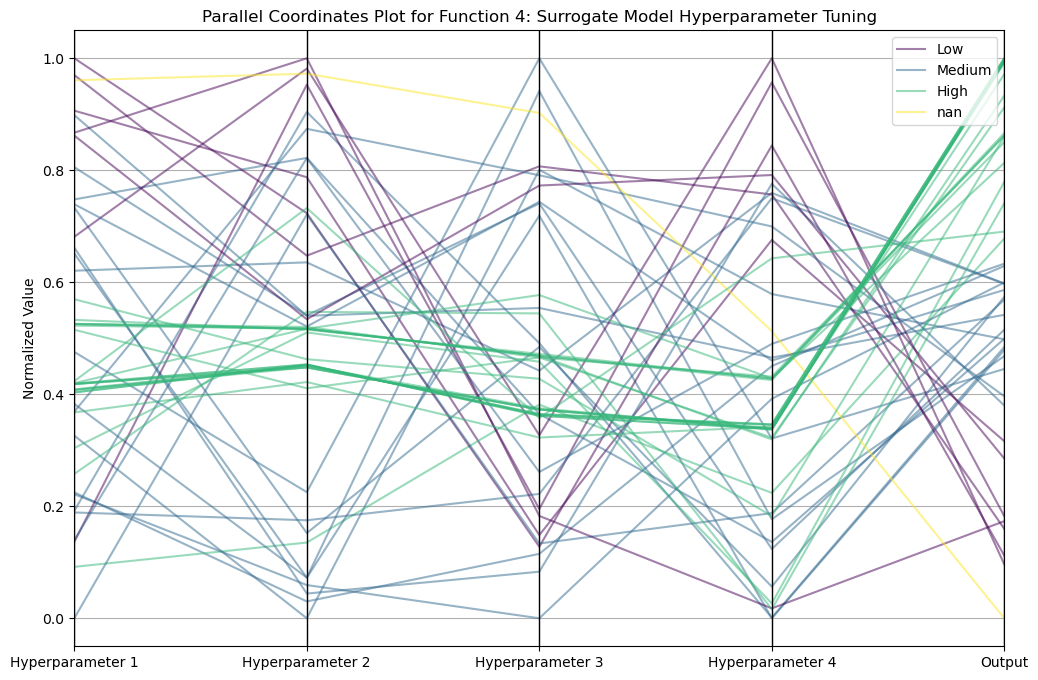

Importance of Hyperparameter 1: 0.3190
Importance of Hyperparameter 2: 0.3061
Importance of Hyperparameter 3: 0.2051
Importance of Hyperparameter 4: 0.2347


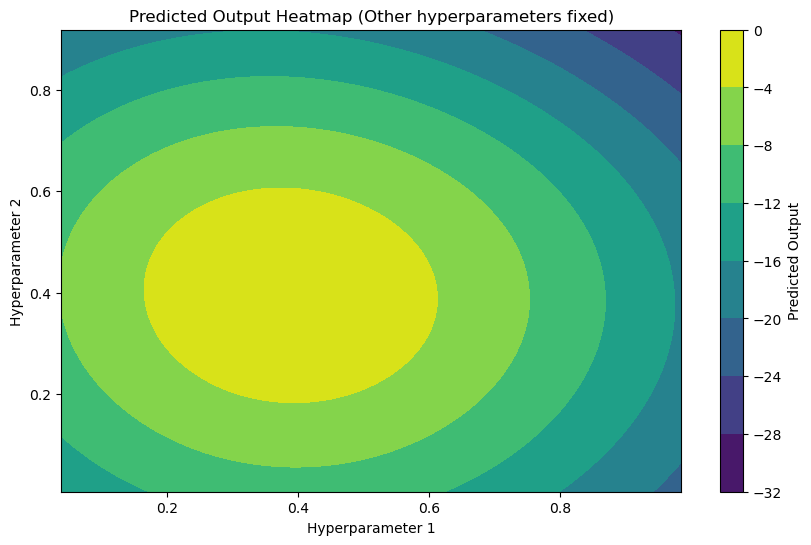

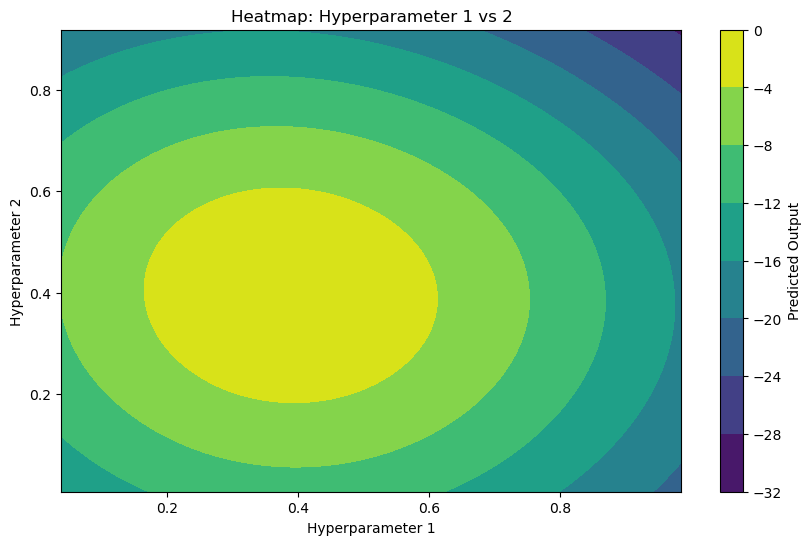

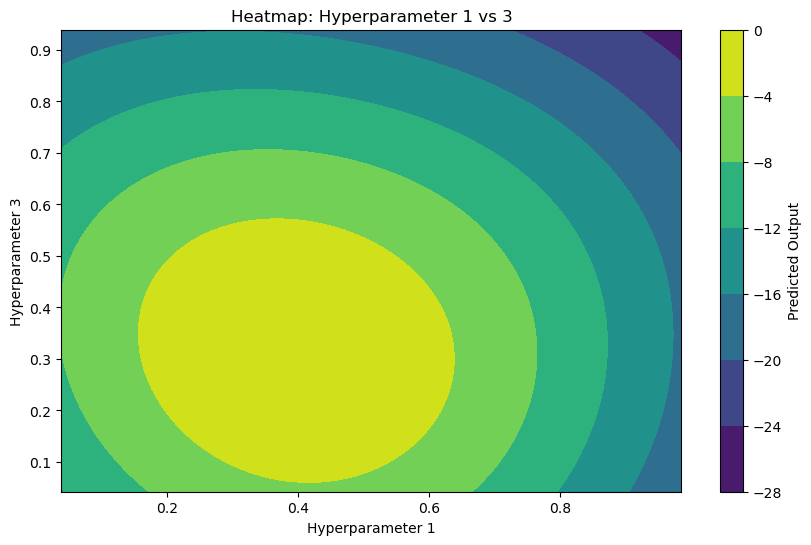

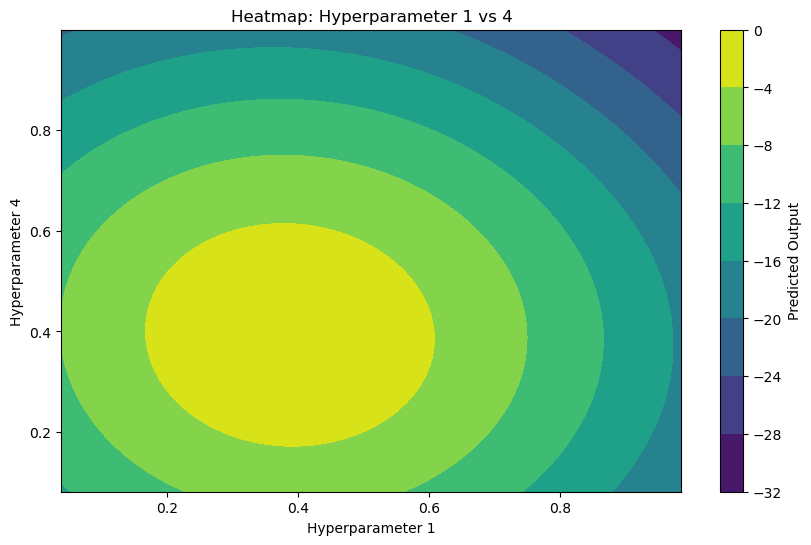

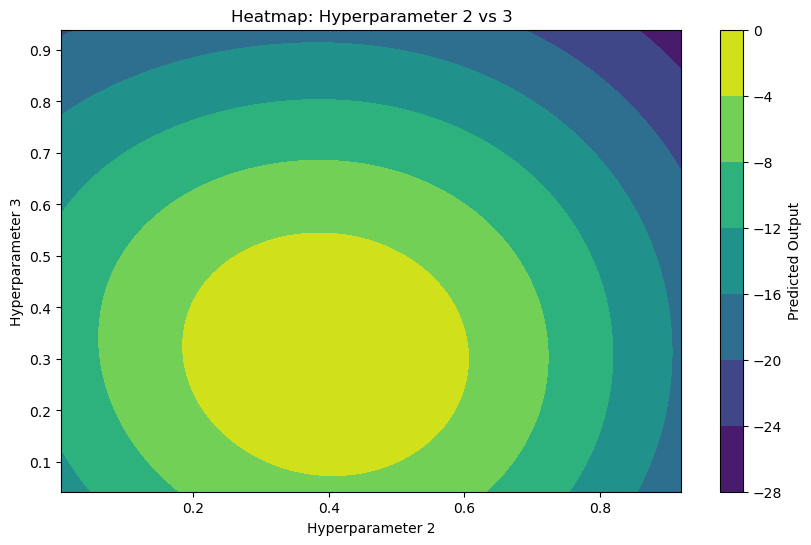

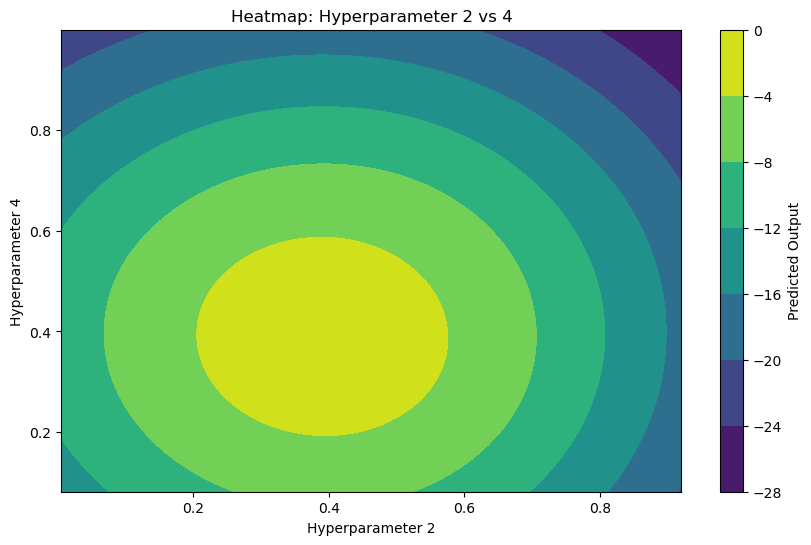

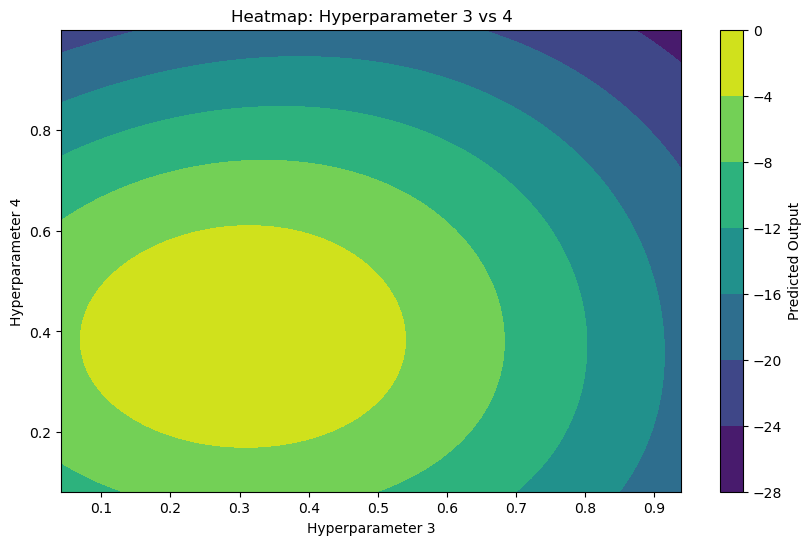

In [3]:
# Thinking about the clues in the problem statement
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from pandas.plotting import parallel_coordinates
from sklearn.inspection import permutation_importance

# Load initial data for Function 4
inputs_f4 = np.load('function_4/initial_inputs.npy')
outputs_f4 = np.load('function_4/initial_outputs.npy')

# Fit Gaussian Process surrogate model (suitable for expensive, dynamic systems)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-6, 1e1), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, alpha=1e-2)
gp.fit(inputs_f4, outputs_f4)
print("Fitted kernel:", gp.kernel_)

# Expected Improvement (EI) acquisition function to handle multiple local optima
def expected_improvement(x, gp, y_max, xi=0.01):
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    with np.errstate(divide='warn'):
        imp = mean - y_max - xi
        Z = imp / std
        ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
        if std == 0.0:
            ei = 0.0
    return -ei

# Identify the current best output (maximization goal)
y_max = np.max(outputs_f4)

# Define bounds from existing input ranges
bounds = [(np.min(inputs_f4[:, i]), np.max(inputs_f4[:, i])) for i in range(inputs_f4.shape[1])]

# Optimize Expected Improvement to find next best input for querying
result = minimize(expected_improvement,
                  x0=np.mean(inputs_f4, axis=0),
                  args=(gp, y_max),
                  bounds=bounds,
                  method='L-BFGS-B')

next_best_input = result.x
print("Suggested next best input (model hyperparameters):", next_best_input)
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_input])


# Predict the output score at the next suggested input
predicted_output, predicted_std = gp.predict(next_best_input.reshape(1, -1), return_std=True)
print("Predicted performance gap at suggested input:", predicted_output[0], "±", predicted_std[0])

# Parallel coordinates visualization for interpretability
feature_columns = [f'Hyperparameter {i+1}' for i in range(inputs_f4.shape[1])]
data_f4 = pd.DataFrame(inputs_f4, columns=feature_columns)
data_f4['Output'] = outputs_f4

scaler = MinMaxScaler()
data_f4_normalized = pd.DataFrame(scaler.fit_transform(data_f4), columns=data_f4.columns)

bins = np.linspace(data_f4_normalized['Output'].min(), data_f4_normalized['Output'].max(), 4)
data_f4_normalized['Performance'] = pd.cut(data_f4_normalized['Output'], bins, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(12, 8))
parallel_coordinates(data_f4_normalized, class_column='Performance', colormap='viridis', alpha=0.5)
plt.title('Parallel Coordinates Plot for Function 4: Surrogate Model Hyperparameter Tuning')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.show()

# Feature Importance using permutation importance
perm_importance = permutation_importance(gp, inputs_f4, outputs_f4, n_repeats=50, random_state=42)
for i, col in enumerate(feature_columns):
    print(f"Importance of {col}: {perm_importance.importances_mean[i]:.4f}")

# Heatmap (if at least 2 dimensions)
if inputs_f4.shape[1] >= 2:
    from matplotlib import cm
    x = np.linspace(np.min(inputs_f4[:, 0]), np.max(inputs_f4[:, 0]), 100)
    y = np.linspace(np.min(inputs_f4[:, 1]), np.max(inputs_f4[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    Z_input = np.zeros((X.size, inputs_f4.shape[1]))
    Z_input[:, 0] = X.ravel()
    Z_input[:, 1] = Y.ravel()
    for i in range(2, inputs_f4.shape[1]):
        Z_input[:, i] = np.mean(inputs_f4[:, i])
    Z_pred = gp.predict(Z_input).reshape(X.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
    plt.title('Predicted Output Heatmap (Other hyperparameters fixed)')
    plt.xlabel('Hyperparameter 1')
    plt.ylabel('Hyperparameter 2')
    plt.colorbar(label='Predicted Output')
    plt.show()

# Residual analysis
predicted_outputs = gp.predict(inputs_f4)
residuals = outputs_f4 - predicted_outputs

# Additional Heatmaps for other hyperparameter pairs
from matplotlib import cm

# Function to plot heatmap for any two dimensions
def plot_heatmap(dim_x, dim_y, fixed_dims, title):
    x = np.linspace(np.min(inputs_f4[:, dim_x]), np.max(inputs_f4[:, dim_x]), 100)
    y = np.linspace(np.min(inputs_f4[:, dim_y]), np.max(inputs_f4[:, dim_y]), 100)
    X, Y = np.meshgrid(x, y)
    Z_input = np.zeros((X.size, inputs_f4.shape[1]))
    Z_input[:, dim_x] = X.ravel()
    Z_input[:, dim_y] = Y.ravel()
    for i in range(inputs_f4.shape[1]):
        if i != dim_x and i != dim_y:
            Z_input[:, i] = np.mean(inputs_f4[:, i])
    Z_pred = gp.predict(Z_input).reshape(X.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
    plt.title(title)
    plt.xlabel(f'Hyperparameter {dim_x+1}')
    plt.ylabel(f'Hyperparameter {dim_y+1}')
    plt.colorbar(label='Predicted Output')
    plt.show()

# Plot heatmaps for all pairs
plot_heatmap(0, 1, [2, 3], 'Heatmap: Hyperparameter 1 vs 2')
plot_heatmap(0, 2, [1, 3], 'Heatmap: Hyperparameter 1 vs 3')
plot_heatmap(0, 3, [1, 2], 'Heatmap: Hyperparameter 1 vs 4')
plot_heatmap(1, 2, [0, 3], 'Heatmap: Hyperparameter 2 vs 3')
plot_heatmap(1, 3, [0, 2], 'Heatmap: Hyperparameter 2 vs 4')
plot_heatmap(2, 3, [0, 1], 'Heatmap: Hyperparameter 3 vs 4')



Fitted kernel: 2.98**2 * Matern(length_scale=1.54, nu=2.5)

New exploitation bounds around best guess (±10%):
Hyperparameter 1: 0.382703 to 0.467748
Hyperparameter 2: 0.377489 to 0.461375
Hyperparameter 3: 0.331700 to 0.405412
Hyperparameter 4: 0.359378 to 0.439240

Suggested next best input (model hyperparameters): [0.38627949 0.39157888 0.3317004  0.39563244]
Suggested next best input (6 decimals): ['0.386279', '0.391579', '0.331700', '0.395632']
Predicted performance gap at suggested input: 0.36645358457174027 ± 0.4700458406002004


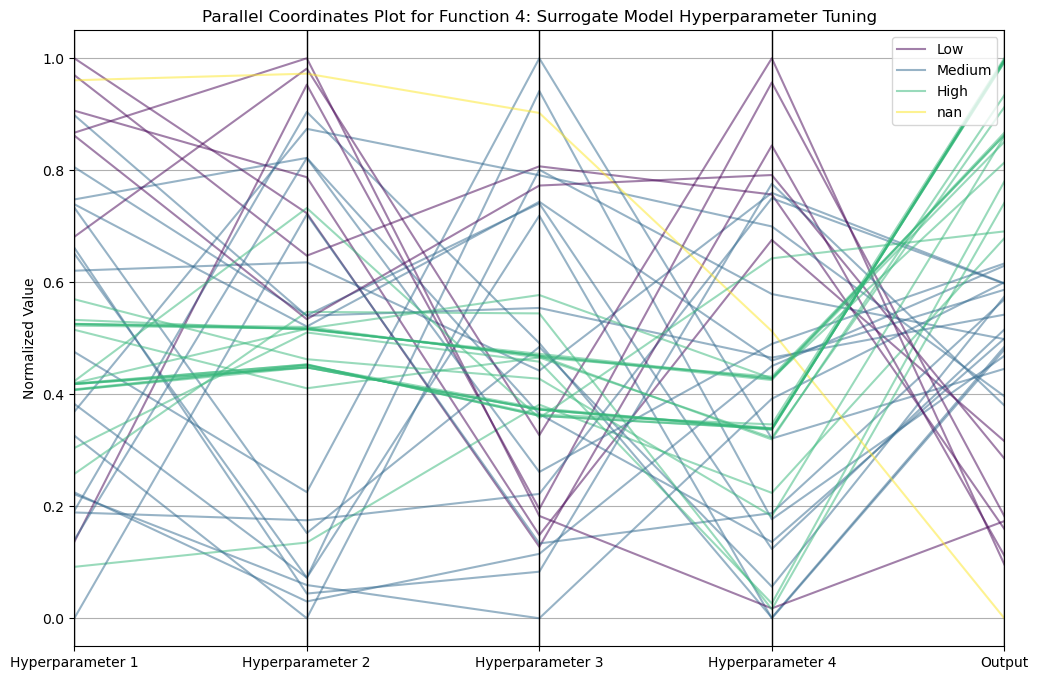

Importance of Hyperparameter 1: 0.3344
Importance of Hyperparameter 2: 0.3296
Importance of Hyperparameter 3: 0.1991
Importance of Hyperparameter 4: 0.2482


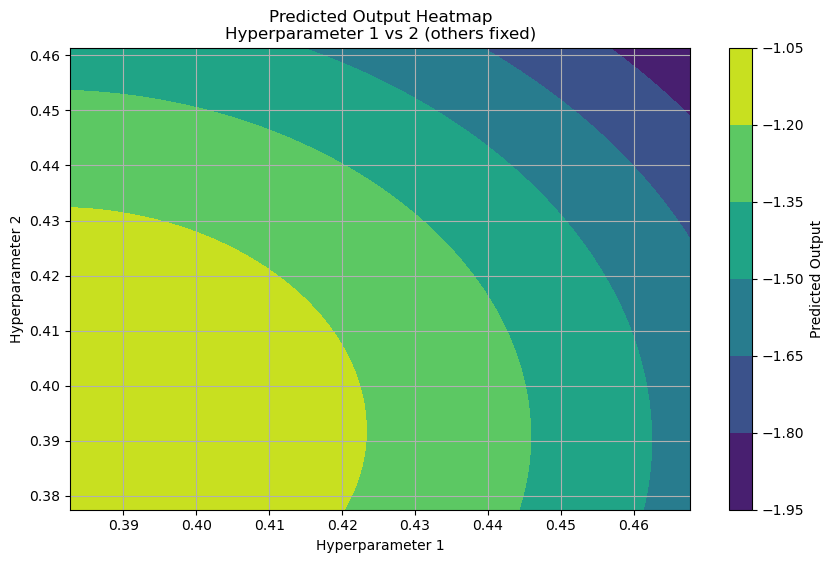

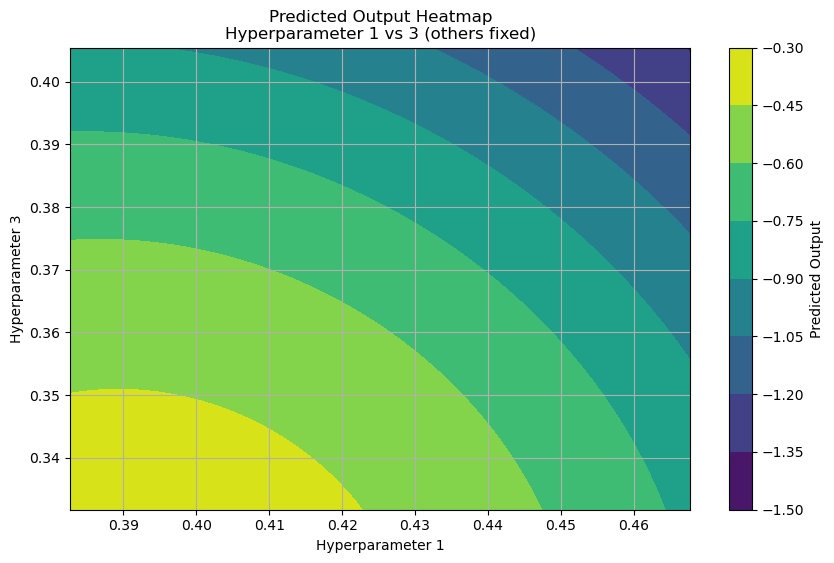

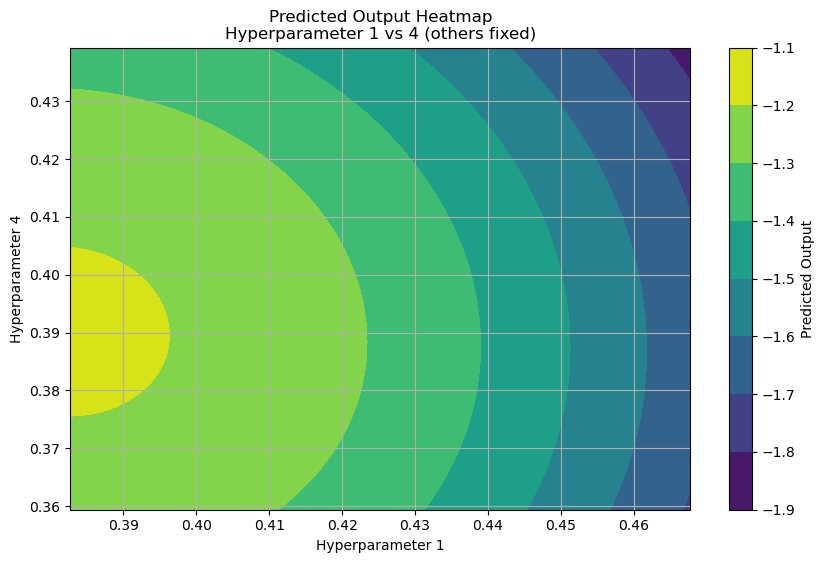

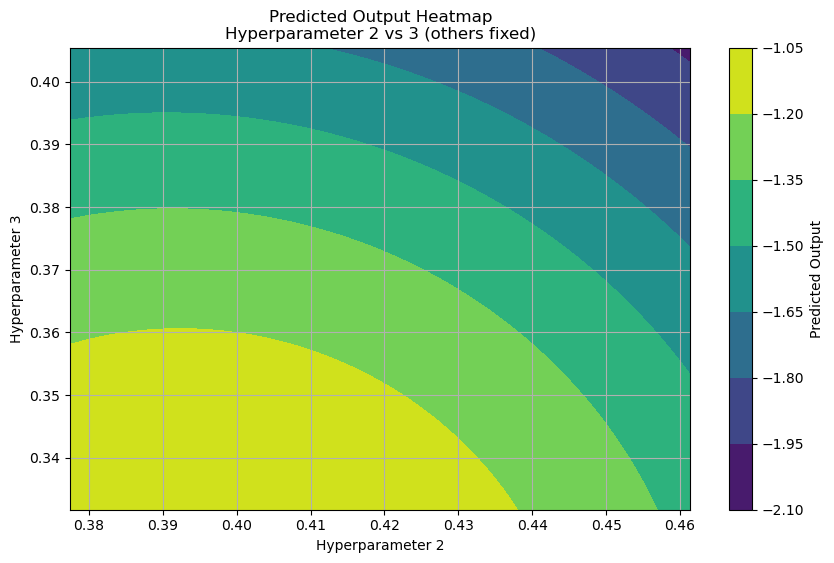

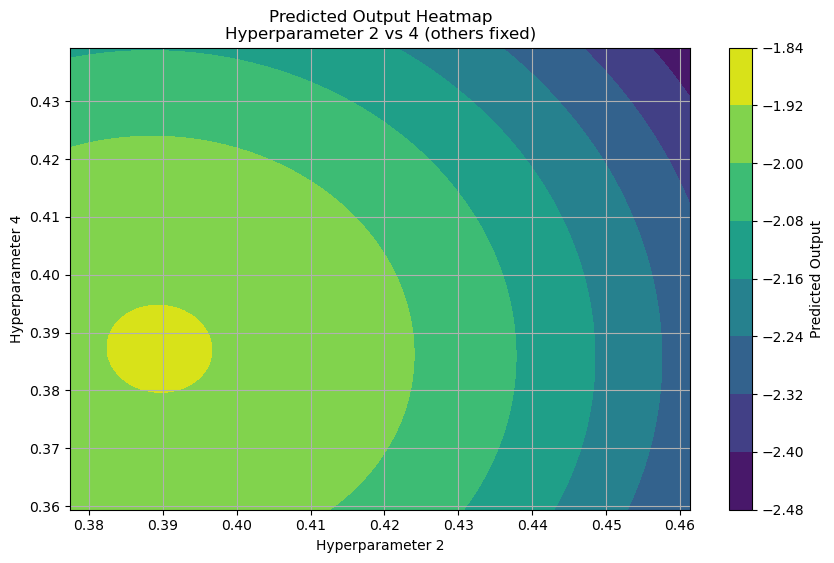

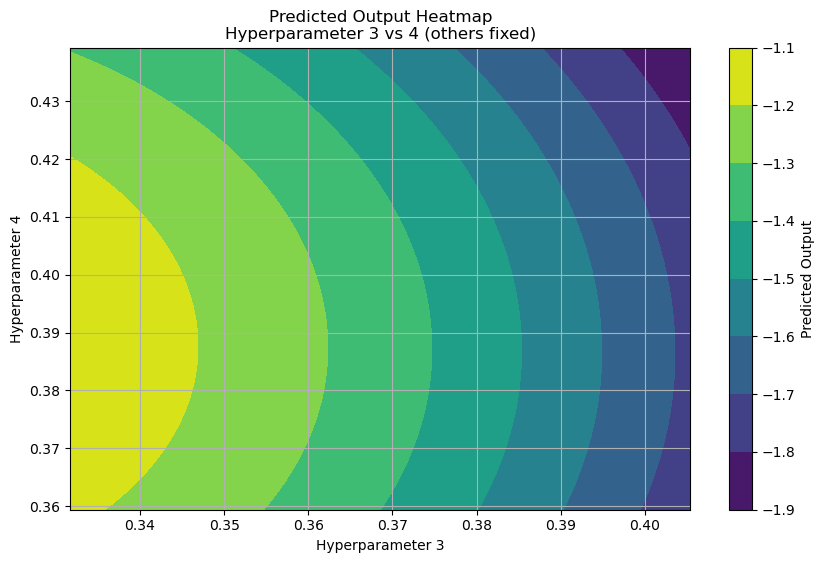

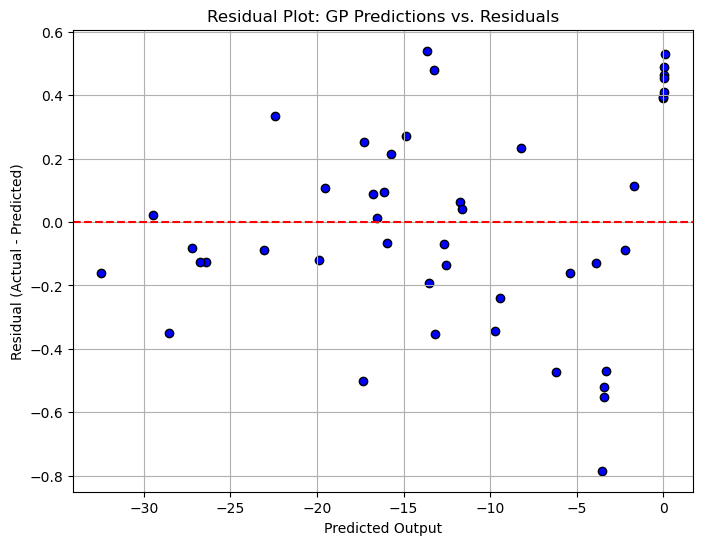

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from pandas.plotting import parallel_coordinates
from sklearn.inspection import permutation_importance
from itertools import combinations

# Load initial data for Function 4
inputs_f4 = np.load('function_4/initial_inputs.npy')
outputs_f4 = np.load('function_4/initial_outputs.npy')

# -------------------------------
# Step 1: Fit Gaussian Process
# -------------------------------
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-6, 1e1), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, alpha=1e-2)
gp.fit(inputs_f4, outputs_f4)
print("Fitted kernel:", gp.kernel_)

# -------------------------------
# Step 2: Define exploitation bounds around a known good point (±10%)
# -------------------------------
center = np.array([0.425225, 0.419432, 0.368556, 0.399309])
radius = 0.1
bounds = [(max(0, c * (1 - radius)), min(1, c * (1 + radius))) for c in center]
print("\nNew exploitation bounds around best guess (±10%):")
for i, (low, high) in enumerate(bounds):
    print(f"Hyperparameter {i+1}: {low:.6f} to {high:.6f}")

# -------------------------------
# Step 3: Expected Improvement acquisition function
# -------------------------------
def expected_improvement(x, gp, y_max, xi=0.01):
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    with np.errstate(divide='warn'):
        imp = mean - y_max - xi
        Z = imp / std
        ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
        if std == 0.0:
            ei = 0.0
    return -ei

# -------------------------------
# Step 4: Suggest next best input (local EI)
# -------------------------------
y_max = np.max(outputs_f4)
result = minimize(expected_improvement,
                  x0=center,
                  args=(gp, y_max),
                  bounds=bounds,
                  method='L-BFGS-B')
next_best_input = result.x
predicted_output, predicted_std = gp.predict(next_best_input.reshape(1, -1), return_std=True)

print("\nSuggested next best input (model hyperparameters):", next_best_input)
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_input])
print("Predicted performance gap at suggested input:", predicted_output[0], "±", predicted_std[0])

# -------------------------------
# Step 5: Parallel Coordinates Visualization
# -------------------------------
feature_columns = [f'Hyperparameter {i+1}' for i in range(inputs_f4.shape[1])]
data_f4 = pd.DataFrame(inputs_f4, columns=feature_columns)
data_f4['Output'] = outputs_f4

scaler = MinMaxScaler()
data_f4_normalized = pd.DataFrame(scaler.fit_transform(data_f4), columns=data_f4.columns)

bins = np.linspace(data_f4_normalized['Output'].min(), data_f4_normalized['Output'].max(), 4)
data_f4_normalized['Performance'] = pd.cut(data_f4_normalized['Output'], bins, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(12, 8))
parallel_coordinates(data_f4_normalized, class_column='Performance', colormap='viridis', alpha=0.5)
plt.title('Parallel Coordinates Plot for Function 4: Surrogate Model Hyperparameter Tuning')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.show()

# -------------------------------
# Step 6: Permutation Feature Importance
# -------------------------------
perm_importance = permutation_importance(gp, inputs_f4, outputs_f4, n_repeats=50, random_state=42)
for i, col in enumerate(feature_columns):
    print(f"Importance of {col}: {perm_importance.importances_mean[i]:.4f}")

# -------------------------------
# Step 7: Generate all 6 heatmaps (pairs of 4 hyperparameters)
# -------------------------------
from matplotlib import cm

pairs = list(combinations(range(inputs_f4.shape[1]), 2))
fixed_values = np.mean(inputs_f4, axis=0)

for (i, j) in pairs:
    x_range = np.linspace(bounds[i][0], bounds[i][1], 100)
    y_range = np.linspace(bounds[j][0], bounds[j][1], 100)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z_input = np.zeros((X.size, inputs_f4.shape[1]))
    Z_input[:, i] = X.ravel()
    Z_input[:, j] = Y.ravel()
    for k in range(inputs_f4.shape[1]):
        if k != i and k != j:
            Z_input[:, k] = fixed_values[k]
    
    Z_pred = gp.predict(Z_input).reshape(X.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z_pred, cmap=cm.viridis)
    plt.title(f'Predicted Output Heatmap\nHyperparameter {i+1} vs {j+1} (others fixed)')
    plt.xlabel(f'Hyperparameter {i+1}')
    plt.ylabel(f'Hyperparameter {j+1}')
    plt.colorbar(label='Predicted Output')
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 8: Residual Analysis
# -------------------------------
predicted_outputs = gp.predict(inputs_f4)
residuals = outputs_f4 - predicted_outputs

plt.figure(figsize=(8, 6))
plt.scatter(predicted_outputs, residuals, c='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: GP Predictions vs. Residuals')
plt.xlabel('Predicted Output')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()
